<a href="https://colab.research.google.com/github/novus-afk/Convection-Diffusion-1D-Steady-State-python/blob/master/cd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
      Copyright 2021 MOHAMMED YAHYA ANSARI

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
'''

In [1]:
# import the required libraries
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
1print("\n \t\t Convection Diffusion Solver\n")
print("\nRead more about this solver in repository readme!")

# get input from user
n = int(input("\n\tEnter the no. of grid points :   "))

l = float(input("\n\tEnter length of plate in m :   "))

u = float(input("\n\tEnter velocity in m/s :   "))

rho = float(input("\n\tEnter density in kg/m3 :   "))

ta = float(input("\n\tEnter left boundary condition :   "))

tb = float(input("\n\tEnter right boundary condition :   "))

g = float(input("\n\tEnter Gamma in kg/ms :   "))


 		 Convection Diffusion Solver


Read more about this solver in repository readme!

	Enter the no. of grid points :   5

	Enter length of plate in m :   1

	Enter velocity in m/s :   2.5

	Enter density in kg/m3 :   1

	Enter left boundary condition :   1

	Enter right boundary condition :   0

	Enter Gamma in kg/ms :   .1


In [3]:
# create list of size n
D = [0]*n
beta = [0]*n
alpha = [0]*n
c = [0]*n
A = [0]*n
C = [0]*n
X = [0]*n
XA = [0]*n
XX = [0]*n
Err = [0]*n

# calculate dx, D and F
dx = l/n
x = g/dx
y = rho*u

In [4]:
# create tdma function
# Define TDMA function very specific to this numerical solver, for general tdma solver refer : https://github.com/novus-afk/TDMA-Solver
def TDMA(n, beta, D, alpha, c):
    beta[0] = 0
    beta[n-1] = beta[1]
    alpha[0] = alpha[1]
    alpha[n-1] = 0
    # copy common values
    for i in range(2, n-1):
        D[i] = D[1]
        beta[i] = beta[1]
        alpha[i] = alpha[1]
    # solve forward substitution
    for i in range(0, n):
        A[i] = alpha[i]/(D[i] - beta[i]*A[i-1])
        C[i] = (beta[i]*C[i-1] + c[i])/(D[i] - beta[i]*A[i-1])

    X[n-1] = C[n-1]
    # solve backward substitution
    j = n-2
    while j >= 0:
        X[j] = A[j] * X[j+1] + C[j]
        j = j-1

    return X

In [5]:
# Create convection diffusion function 
def CD():
    D[0] = (3*x)+y/2
    D[1] = 2*x
    D[n-1] = (3*x)-y/2

    beta[1] = x+y/2
    alpha[1] = x-y/2

    c[0] = ((2*x)+y)*ta
    c[n-1] = ((2*x)-y)*tb
    for i in range(1, n-1):
        c[i] = 0

In [6]:
# create upwind function
def UPWIND():
    D[0] = (3*x)+y
    D[1] = (2*x)+y
    D[n-1] = (3*x)+y

    beta[1] = x+y
    alpha[1] = x

    c[0] = ((2*x)+y)*ta
    c[n-1] = 2*x*tb
    for i in range(1, n-1):
        c[i] = 0

In [7]:
# Switch case for type of numerical
choice = ""
while choice != "q":
    print("""\n\t\tSelect a Scheme :
        
        [ 1 ] Central Differencing Scheme

        [ 2 ] UPWIND Scheme

        [ q ] Exit\n""")
    choice = input("\n\tEnter Choice :\t")

    if choice == "1":
        print("\n---> Central Differencing Scheme\n")
        CD()
        temp = TDMA(n, beta, D, alpha, c)
        break

    elif choice == "2":
        print("\n---> UPWIND Scheme\n")
        UPWIND()
        temp = TDMA(n, beta, D, alpha, c)
        break

    elif choice == "q":
        exit()

    else:
        print("\n\n\tInvalid choice, Try again!\n")


		Select a Scheme :
        
        [ 1 ] Central Differencing Scheme

        [ 2 ] UPWIND Scheme

        [ q ] Exit


	Enter Choice :	1

---> Central Differencing Scheme



In [8]:
# analytical solution
for w in range(0, n):
    XX[w] = dx*0.5 + (dx * w)
    n1 = rho * u * XX[w] / g
    n2 = rho * u * l / g
    XA[w] = ta + (((math.exp(n1)-1)/(math.exp(n2)-1))*(tb-ta))
    Err[w] = ((XA[w] - X[w]) * 100*2) / (XA[w] + X[w])

In [9]:
# Create data for Pandas DataFrame
OUTPUT = list(zip(beta, D, alpha, c, A, C, X, XA, Err))
# create Pandas DataFrame
result = pd.DataFrame(data=OUTPUT, columns=[
                      "\N{GREEK SMALL LETTER BETA}", "Diagonal (D)", "\N{GREEK SMALL LETTER ALPHA}", "Constants", "A", "C'", "X", "X-Analytical", "% Error"])
# Change index to 1,2,3,.....
result.index = result.index + 1
print(result)

      β  Diagonal (D)     α  Constants         A        C'         X  \
1  0.00          2.75 -0.75        3.5 -0.272727  1.272727  1.035630   
2  1.75          1.00 -0.75        0.0 -0.507692  1.507692  0.869355   
3  1.75          1.00 -0.75        0.0 -0.397149  1.397149  1.257331   
4  1.75          1.00 -0.75        0.0 -0.442475  1.442475  0.352053   
5  1.75          0.25  0.00       -0.0  0.000000  2.464370  2.464370   

   X-Analytical    % Error  
1      1.000000  -3.500684  
2      1.000000  13.977564  
3      0.999996 -22.799978  
4      0.999447  95.803814  
5      0.917915 -91.444377  



********** Plot Graph complete **********

* * * * *   Graph Displayed   * * * * *

*****     Close Graph to Continue     *****



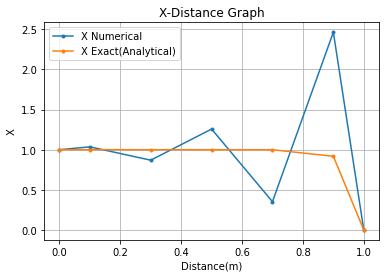

In [10]:
# plot and show graph
# adding initial and final conditions to the list, as list contains values at nodes
X.insert(0, ta)
X.append(tb)
XA.insert(0, ta)
XA.append(tb)
XX.insert(0, 0)
XX.append(l)

graph = pd.DataFrame({'X Numerical': X, 'X Exact(Analytical)': XA}, index=XX)
# graph.plot()
plt.plot(graph, marker='.')
plt.title("X-Distance Graph")
plt.xlabel("Distance(m)")
plt.ylabel("X")
plt.grid()
plt.legend(['X Numerical', 'X Exact(Analytical)'])
figure = plt.gcf()
print('''\n********** Plot Graph complete **********

* * * * *   Graph Displayed   * * * * *

*****     Close Graph to Continue     *****\n''')
plt.show()

In [ ]:
# # save result ot excel sheet
# export = ""
# while export != "q":
#     print("""\n\n\t[ y ] Enter y to export table and graph to output folder.
    
#         [ q ] Enter q to exit without exporting.\n\n""")
#     export = input("Enter your choice :   \t")

#     if (export == "y"):
#         # add serial no  column at the start of the DataFrame
#         result.insert(0, 'Sr.No.', range(1, 1 + len(result)))
#         # .to_excel to export excel file
#         result.to_excel('output/CD.xlsx', sheet_name='Output', index=False)
#         # save graph
#         figure.savefig("output/graph.png")
#         print("\n\n*************** Export result to output folder complete. ***************\n\n")
#         break

#     elif (export == "q"):
#         print("\n\n***** Result not saved to excel. *****\n\n")
#         break

#     else:
#         print("\n\t\tInvalid Choice, Try again!")


# input("Press Enter to exit")